<a href="https://colab.research.google.com/github/kamil5555579/machine_learning/blob/main/Kopia_notatnika_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [6]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2023-04-26 07:20:06--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   284MB/s    in 0.2s    

2023-04-26 07:20:06 (284 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))


In [37]:
# 3

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=(IMG_HEIGHT,IMG_WIDTH))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=batch_size,
                                                            image_size=(IMG_HEIGHT,IMG_WIDTH))

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir ,
                                                                 shuffle=False,
                                                                 batch_size=batch_size,
                                                            image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           labels=None)

class_names = train_dataset.class_names


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files belonging to 1 classes.


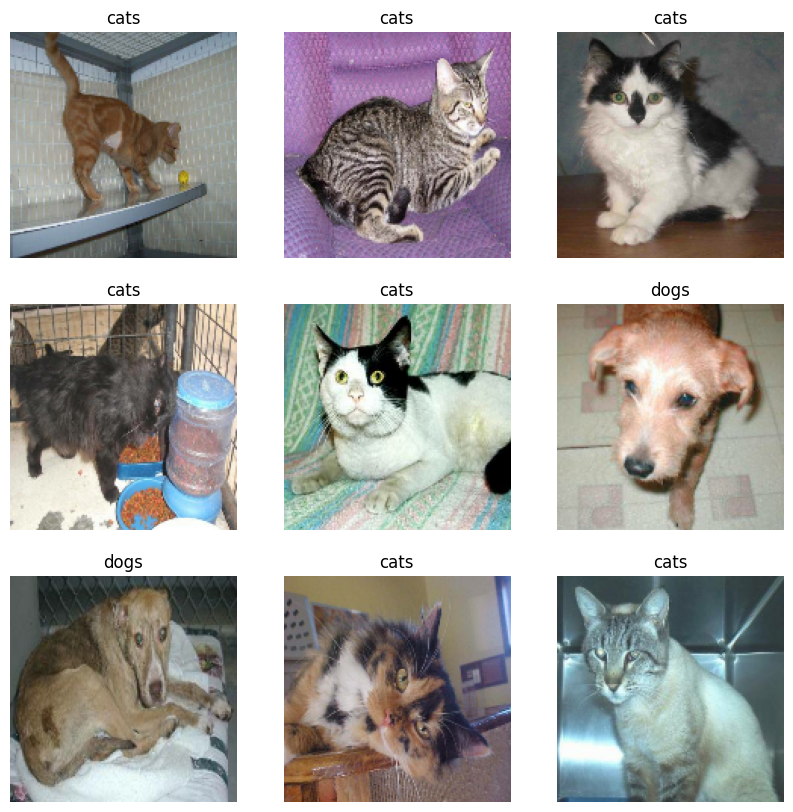

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

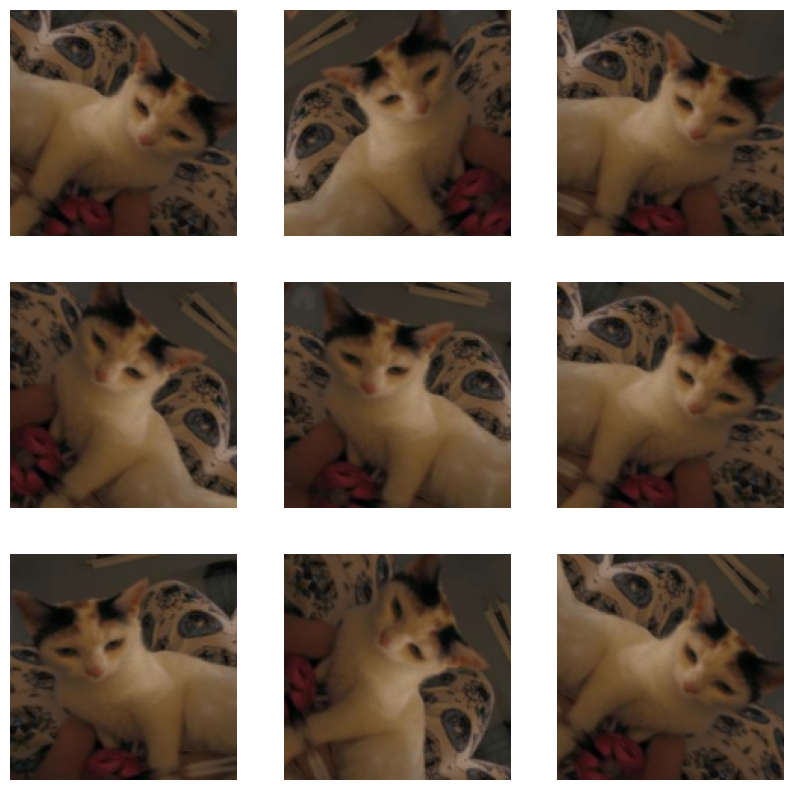

In [41]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [69]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = (IMG_WIDTH,IMG_HEIGHT) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

(128, 5, 5, 1280)


In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [47]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [53]:
# 7
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [54]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
# 8
history =  model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/15
16/16 [==============================] - 51s 3s/step - loss: 0.9473 - accuracy: 0.4935 - val_loss: 0.6923 - val_accuracy: 0.6130
Epoch 2/15
16/16 [==============================] - 54s 3s/step - loss: 0.8028 - accuracy: 0.5735 - val_loss: 0.5764 - val_accuracy: 0.6960
Epoch 3/15
16/16 [==============================] - 49s 3s/step - loss: 0.6851 - accuracy: 0.6345 - val_loss: 0.4851 - val_accuracy: 0.7620
Epoch 4/15
16/16 [==============================] - 48s 3s/step - loss: 0.6119 - accuracy: 0.6965 - val_loss: 0.4122 - val_accuracy: 0.8060
Epoch 5/15
16/16 [==============================] - 40s 2s/step - loss: 0.5396 - accuracy: 0.7365 - val_loss: 0.3565 - val_accuracy: 0.8350
Epoch 6/15
16/16 [==============================] - 47s 3s/step - loss: 0.5005 - accuracy: 0.7490 - val_loss: 0.3127 - val_accuracy: 0.8700
Epoch 7/15
16/16 [==============================] - 38s 2s/step - loss: 0.4475 - accuracy: 0.7860 - val_loss: 0.2788 - val_accuracy: 0.8850
Epoch 8/15
16/16 [==

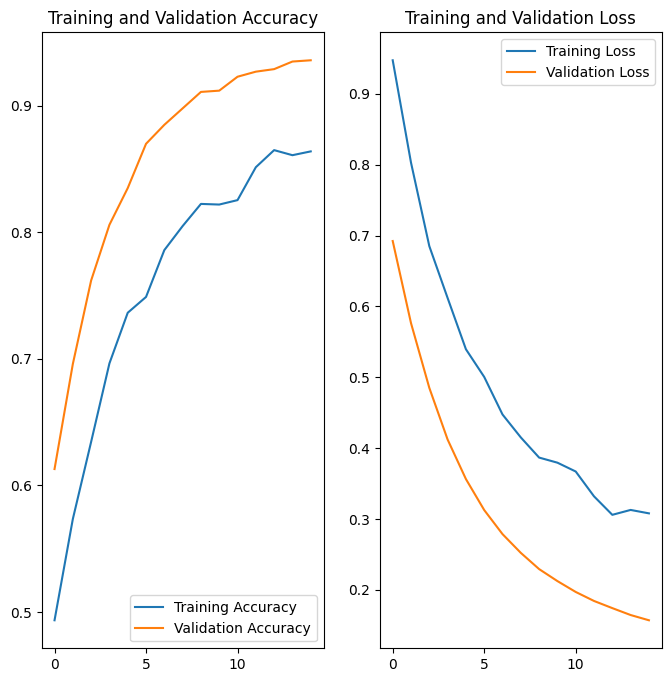

In [56]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [0.9304686  0.00781592 0.01108916 0.9521168  0.02845322 0.2235487
 0.09305752 0.04046501 0.832171   0.99423224 0.20032851 0.93812764
 0.07944163 0.8960837  0.087432   0.9731042  0.8076153  0.2887949
 0.83840454 0.94195586 0.00653783 0.05958367 0.9837378  0.9514609
 0.9440638  0.12997477 0.97694975 0.02014074 0.00801388 0.1081842
 0.01447862 0.06877634 0.8774245  0.79455674 0.01738352 0.63331205
 0.9942532  0.9908319  0.9735526  0.01605837 0.73700094 0.00711153
 0.9794496  0.97490543 0.0244928  0.04041157 0.11143211 0.1816121
 0.0044691  0.00889459]


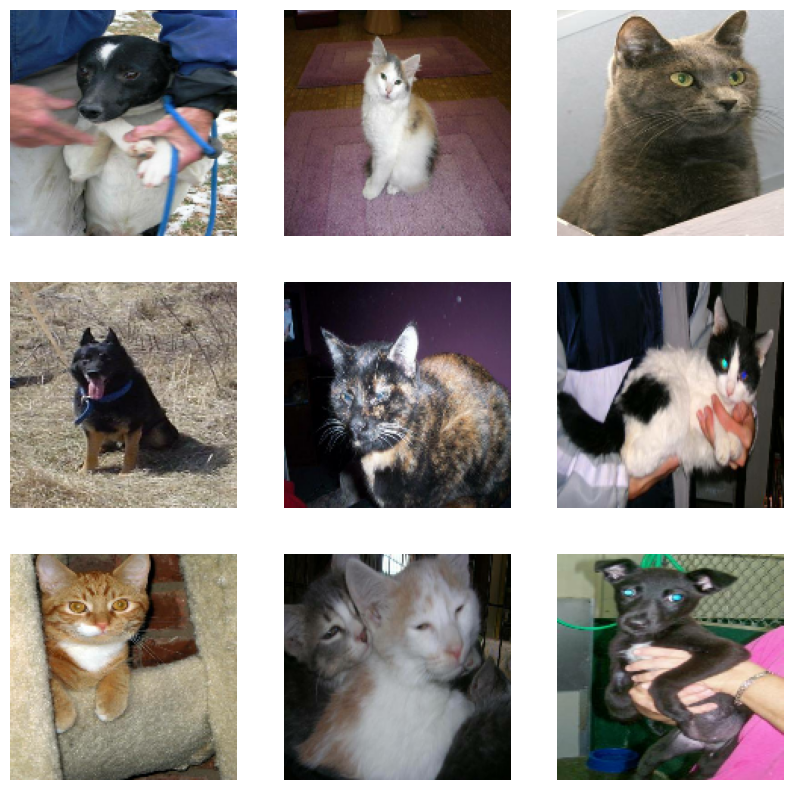

In [67]:
# Retrieve a batch of images from the test set
image_batch= test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions).numpy()
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions)
#print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  #plt.title(class_names[predictions[i]])
  plt.axis("off")

In [68]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(predictions, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 98.0% of the images of cats and dogs.
You passed the challenge!
